In [88]:
import jax 
import ticktack
import matplotlib.pyplot as pyplot
# import jupyterthemes
import functools

# jupyterthemes.jtplot.style()

In [25]:
model = ticktack.load_presaved_model("Guttler15", production_rate_units="atoms/cm^2/s")
model.compile()

MATRIX = model._matrix
PROJECTION = model._production_coefficients

del model

In [26]:
def load(filename: str, /, sep: str=","):
    """
    A custom `JAX` file loading protocol designed to be very quick and return a value that is `JAX` transformable. 
    
    Parameters:
        filename: String -> The file address of the data
    Returns:
        DeviceArray -> The data in column major order
    """
    with open(filename) as data:    # Opening the data file
        _ = next(data)              # Header row for the data 

        data = jax.numpy.array(
            [row.strip().split(sep) for row in data], 
            dtype=jax.numpy.float64
        )
        
        return data.T

In [27]:
time_out = jax.numpy.linspace(0, 10, 100)

In [28]:
multiply = jax.jit(jax.vmap(jax.numpy.multiply, in_axes=(None, 0)))
matrix_multiply = jax.jit(jax.vmap(jax.numpy.matmul, in_axes=(0, None)))

In [29]:
eigenvals, eigenvecs = jax.numpy.linalg.eig(MATRIX)
eigenvecs, eigenvals = eigenvecs.real, eigenvals.real
inverse = jax.numpy.linalg.inv(eigenvecs)
initial_position = 1.0 / jax.numpy.linalg.norm(PROJECTION) * PROJECTION

In [30]:
@jax.jit
def fundamental_matrix(time_out, /, eigenvecs=eigenvecs, eigenvals=eigenvals, inverse=inverse):
    """
    This constructs the right hand side of the fundamental solution matrix. It is vectorised and so returns a three dimensional array with the third dimension spanning the time series implied by `time_out`.

    Parameters:
    -----------
    : time_out :  The time series over which the fundamental matrix is to be calculated
    : eigenvecs : The eigenvectors of the transfer matrix
    : eigenvals : The eigenvalues of the transfer matrix
    : inverse : The inverse of the eigenvectors of the transfer matrix. This could be calculated internally but since the evaluation is only required once it is passed as an argument.

    Returns:
    --------
    : DeviceArray : The fundamental solution matrix evaluated over the time series implied by `time_out`
    """
    # So I need to implement the translation of the time series back onto 0
    exponents = jax.numpy.exp(multiply(eigenvals, time_out))
    transition_matrix = multiply(eigenvecs, exponents)
    transition_matrix = matrix_multiply(transition_matrix, inverse)
    return transition_matrix

In [31]:
@jax.jit
def analytic_template(time_out, /, initial_poisition=initial_position):
    """
    Determines the analytic solution of an impulse response function over the time series provided by `time_out`.

    Parameters:
    -----------
    : time_out : The time series at which the analytic solution is to be evaluated
    : inverse : The inverse of the eigenvectors of the transfer matrix
    
    """
    transition_matrix = fundamental_matrix(time_out - time_out.min())
    return matrix_multiply(transition_matrix, initial_poisition)

In [32]:
intcal = load("/home/jordan/Documents/ticktack/src/data/datasets/IntCal20/Intcal20.csv")

In [33]:
@jax.jit
def design_matrix(time_series):
    """
    Constructs the design matrix of the linear regression. 
    
    Parameters:
    -----------
    : time_series : The time over which to evaluate the design matrix.
    
    Returns:
    --------
    : DeviceArray : A 3 by n matrix where n is the length of `time_series`.
    """
    constant = jax.numpy.ones((time_series.shape), dtype=jax.numpy.float64)
    # So I think that the prescence of the zero values is going to cause problems
    # I need to look into the `jax.lax.dynamic_slice_update()` to fix this.
    temporal = (time_series - time_series.min()) / time_series.ptp()
    analytic = analytic_template(time_series)[:, 1]
    return jax.numpy.stack([constant, temporal, analytic])

In [50]:
# These are all utility functions for the bad boy 
# The in_window function is causing headaches because it cannot be passed the data
@jax.jit
def in_window(start, data, size):
    @jax.vmap
    def comp_util(start):
        return (data[0] >= start) & (data[0] < start + size)
    return comp_util(start)

vec_mat = jax.jit(jax.vmap(design_matrix)) # Vectorising the deisgn matrix command
vec_reg = jax.jit(jax.vmap(jax.numpy.linalg.lstsq)) # Vectorising the lstq function 
vec_matmul = jax.jit(jax.vmap(jax.numpy.matmul))

In [35]:
@jax.jit
def vec_regression(data, /, size: int=10):
    start = data[0, :-size] # Storing as a variable for the usefulness 
    mask = in_window(start, data=data, size=size)      # Creates a boolean mask of out of date
    lead_dim = data[0].size      # A useful size parameter for the mapping 

    indices = jax.numpy.arange(start.size) # Inex entry points to get a fill value
    fill_values = jax.numpy.take(data, indices, axis=1) # Data sliced along dimension
    fill_values = fill_values.repeat(lead_dim) # Element wise repetition
    fill_values = fill_values.reshape(3, -1, lead_dim)

    data = data.tile(start.size) # Replicating the data 
    data = data.reshape(3, -1, lead_dim) # Shaping for a push through where

    # The error is here. Where is not pulling the correct data out
    masked_data = jax.numpy.where(mask, data, fill_values)
    masked_matrix = vec_mat(masked_data[0]) # Building the design matrixes

    input_arr = jax.numpy.transpose(masked_matrix, axes=(0, 2, 1)) # Gettinf the sahpe compatible with the leading dimesnion of the data
    lst_square = vec_reg(input_arr, masked_data[1])[0] # Performing regression 
    
    models = vec_matmul(lst_square, masked_matrix) # Running the models
    chi_squared = jax.numpy.sum((masked_data[1] - models) ** 2 / masked_data[2] ** 2, axis=1)
    return jax.numpy.hstack([lst_square, chi_squared.reshape(-1, 1)])

In [140]:
batched_vec_reg =jax.vmap(vec_regression)

# The idea is to run the injection recovery in batches. I don't remeber getting the nans as 
# outputs with the slower function. That said I don't remember looking too closely at the 
# output. I think they might be legit but I don't know

In [138]:
batched_dim = intcal.shape[1] # Chosing the largest dimension to batch along
num_batches = 8 # Number of batches (must be multiple)
leading_dim = batched_dim // num_batches # Length of the new leading dim
batched_data = intcal.reshape(3, leading_dim, num_batches) # Conforming array to batches
batched_data = jax.numpy.transpose(batched_data, axes=(2, 0, 1)) # Placing the map axis in front

In [ ]:
batched_vec_reg(batched_data)

In [95]:
group_one = vec_regression(intcal[:, :1000])

In [101]:
coefficients = group_one[:, 2]
nan_mask = jax.numpy.isnan(coefficients)
indices = jax.numpy.arange(coefficients.size)
nan_index = indices * nan_mask
# coefficients = jax.numpy.delete(coefficients, nan_index)

In [102]:
nan_index

DeviceArray([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
               0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
               0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
               0,   0,   0,   0,   0,   0,   0,   0,  44,   0,   0,   0,
               0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
               0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
               0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
               0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
               0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
               0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
               0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
               0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
               0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
               0,   0,   0,   0,   0,   0,   0,   0

In [103]:
hist_vals = list(map(float, coefficients))

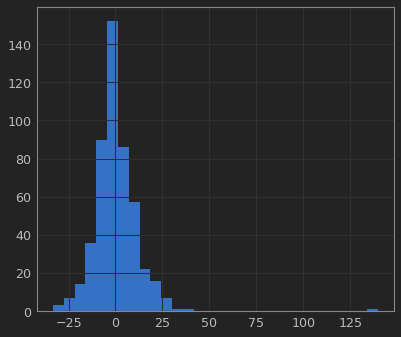

In [107]:
pyplot.figure(0)
pyplot.hist(hist_vals, bins=30)
pyplot.show()